In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt, matplotlib
import numpy as np, healpy as hp, h5py
from scipy import stats, special, linalg, optimize
import scipy
import emcee, tqdm, corner

from pylab import cm

In [3]:
# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)

In [4]:
import emcee, corner

In [5]:
%config Completer.use_jedi = False

## Likelihood model

In [6]:
def loglike(l, Cl, a, gamma):
    return np.sum(gamma * np.log(a+l) - 0.5*(a+l)**(2*gamma) * (1/(a+l)**gamma - Cl)**2)

def loglike(l, Cl, params, grad=False):
    if not grad:
        x = (2*l+1)*Cl / model(l, params)
        lnl = np.sum( (l-0.5)*np.log(x)-x/2 )
        if np.isnan(lnl): print(params)
        return lnl
    else: 
        mod_vals, mod_grad = model(l, params, grad=grad)
        x = (2*l+1)*Cl / mod_vals
        x_prime = -(2*l+1)*Cl / mod_vals**2 * mod_grad
        lnl_val = np.sum( (l-0.5)*np.log(x)-x/2 )
        lnl_grad = np.sum( x_prime * ((l-0.5)/x - 1/2) , axis=1)
        
        return lnl_val, lnl_grad

def model(l, params):
    A = np.exp(params[0])
    gamma=params[1]
    return A*(l+1)**gamma

def model(l, params, grad=False):
    A = np.exp(params[0])
    a = np.exp(params[1])
    gamma=params[2]
    mod_vals = A*(a*(l+1)/(a+l))**gamma
    if not grad: return mod_vals
    mod_grad = np.array([A*(a*(l+1)/(a+l))**gamma,
                         A*(a*(l+1)/(a+l))**gamma * (gamma*l)/(a*(a+l)) * a,
                         A*(a*(l+1)/(a+l))**gamma * np.log(a*(l+1)/(a+l))])
    return mod_vals, mod_grad

def model(l, params, grad=False):
    A = np.exp(params[0])
    gamma=params[1]
    mod_vals = A*(l+1)**gamma
    if not grad: return mod_vals
    mod_grad = np.array([A*(l+1)**gamma,
                         A*(l+1)**gamma * np.log(l+1)])
    return mod_vals, mod_grad

In [7]:
logit = lambda p: np.log(p/(1-p))

In [8]:
_downgrade = lambda A: A.reshape(M, A.shape[0]//M, 
                                 C, A.shape[1]//C, 
                                 hp.nside2npix(nside), A.shape[2]//hp.nside2npix(nside)).sum(axis=(1,3,5))

## Astrometry

In [ ]:
gaiaedr3_astrometry_kncounts_Gres1hpx5.h

In [18]:
M = 17; C=1; nside=64
box={};
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts_arr_hpx128.h', 'r') as hf:
    box['n'] = np.sum(hf['n'][...].reshape(*hf['n'][...].shape[:2], -1,4), axis=(3))
    box['k'] = np.sum(hf['k'][...].reshape(*hf['k'][...].shape[:2], -1,4), axis=(3))
    M_bins = hf['magbins'][...]
box['n'] = _downgrade(box['n'])
box['k'] = _downgrade(box['k'])
magbins = np.linspace(M_bins[0], M_bins[-1], M+1)

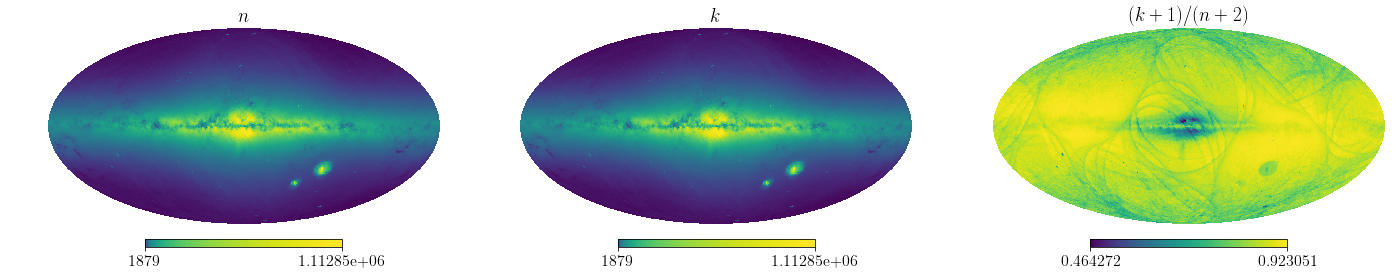

In [10]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(24,5))

minmax = np.min(box['n']), np.max(box['n'])

plt.sca(axes[0])
hp.mollview(np.sum(box['n'], axis=(0,1)), nest=True, notext=True, norm='log',# min=minmax[0], max=minmax[1],
            coord=['C','G'], title=r'$n$', cmap='viridis', hold=True, cbar=True, xsize=2000)

plt.sca(axes[1])
hp.mollview(np.sum(box['n'], axis=(0,1)), nest=True, notext=True, norm='log',#min=minmax[0], max=minmax[1],
            coord=['C','G'], title=r'$k$', cmap='viridis', hold=True, cbar=True, xsize=2000)

plt.sca(axes[2])
hp.mollview((np.sum(box['k'], axis=(0,1))+1)/(np.sum(box['n'], axis=(0,1))+2), nest=True, notext=True, norm='log',
            coord=['C','G'], title=r'$(k+1)/(n+2)$', cmap='viridis', hold=True, cbar=True, xsize=2000)

In [130]:
from scipy import special
p=1.0; B=2.0; F=1e-6; j=5
G = -p*special.lambertw(-np.power(F,1.0/p)/np.e,k=-1).real*np.power(B,2.0*j)
int(np.ceil(0.5*(-1.0+np.sqrt(1.0+4.0*G))))

135

# Load in spectra

In [23]:
with h5py.File('/data/asfe2/Projects/astrometry/gaiaedr3_astrometry_kncounts_M17C1nside128_spectra.h', 'r') as hf:
        spectrum_full = hf['spectra_full'][...]
        spectra = hf['spectra'][...]
        magbins = hf['magbins'][...]
        M, C, P = hf['res'][...]

In [24]:
lmax=400; lmax_fit=135
lvals = np.arange(lmax+1)
    
# x = logit((np.sum(box['k'], axis=(0,1))+1)/(np.sum(box['n'], axis=(0,1))+2))
# spectrum_full = hp.anafast(x, lmax=lmax)

In [25]:
nll = lambda x: -loglike(lvals[:lmax_fit], spectrum_full[:lmax_fit], x)
result = scipy.optimize.minimize(nll, np.array([0.,-2]), method='Powell')
result

   direc: array([[ 0.        ,  1.        ],
       [ 1.46992145, -0.33257953]])
     fun: -33308.80320063946
 message: 'Optimization terminated successfully.'
    nfev: 86
     nit: 3
  status: 0
 success: True
       x: array([-0.67248193, -2.35089366])

In [26]:
def nll(x):
    lnl, lnl_grad = loglike(lvals[:lmax_fit], spectrum_full[:lmax_fit], x, grad=True)
    return -lnl, -lnl_grad

result= scipy.optimize.minimize(nll, result['x'], method='Newton-CG', jac=True, options={'maxiter':1000})
result

     fun: -33308.8034698529
     jac: array([-3.48728348e-06, -1.00620080e-05])
 message: 'Warning: Desired error not necessarily achieved due to precision loss.'
    nfev: 45
    nhev: 0
     nit: 2
    njev: 42
  status: 2
 success: False
       x: array([-0.67227719, -2.35088458])

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/17 [00:00<?, ?it/s]

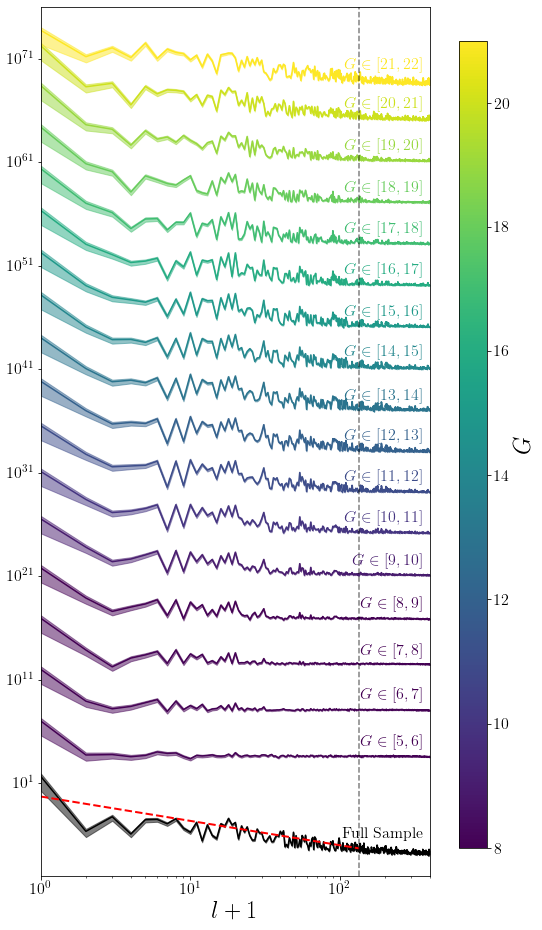

In [29]:
fig, ax = plt.subplots(1,1,figsize=(8,16))

cmap = cm.viridis; mmin=8.; mmax=21.

var_lower = scipy.stats.chi2.ppf(0.16, 2*lvals+1)/(2*lvals+1)
var_upper = scipy.stats.chi2.ppf(0.84, 2*lvals+1)/(2*lvals+1)
offset = 5; shift=2

for i, mag in tqdm.tqdm_notebook(enumerate(magbins[:-1]), total=len(magbins[:-1])):    
    spectrum = spectra[i,0].copy()
    plt.plot(lvals+1, spectrum*10**(2*float(offset+shift*i)), color=cmap((mag-mmin)/(mmax-mmin)))
    plt.fill_between(lvals+1, spectrum*var_lower*10**(2*float(offset+shift*i)), 
                    spectrum*var_upper*10**(2*float(offset+shift*i)), color=cmap((mag-mmin)/(mmax-mmin)),
                    alpha=0.5)

    plt.text(lmax*0.9, spectrum[lmax_fit]*10**(2*float(offset+shift*i+0.5)), r'$G\in[%.0f,%.0f]$'%(magbins[i],magbins[i+1]),
             ha='right', color=cmap((mag-mmin)/(mmax-mmin)))

spectrum = spectrum_full.copy()

plt.plot(lvals+1, spectrum, color='k')
plt.fill_between(lvals+1, spectrum*var_lower, spectrum*var_upper, color='k', alpha=0.5)
plt.plot(np.arange(lmax_fit)+1, model(np.arange(lmax_fit), result['x']),  '--r', linewidth=2)
plt.text(lmax*0.9, spectrum[lmax_fit]*10**(2*0.7), r'Full Sample', ha='right', color='k')
    

plt.yscale('log'); plt.xscale('log'); plt.xlabel(r'$l+1$', fontsize=24)
plt.ylim(np.min(spectrum_full/100), np.max(spectra[-1]*10**(2*float(offset+shift*(M-1)+0.15))*100))
plt.plot([lmax_fit,lmax_fit],[ax.get_ylim()[0],ax.get_ylim()[1]],'--k', alpha=0.5)
plt.xlim(1,lmax+1)


# Adding cbar axes to subplots
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=24)

plt.savefig('figs/powerspectrum_plfit_ast.png', bbox_inches='tight', facecolor='w', transparent=False)

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/17 [00:00<?, ?it/s]

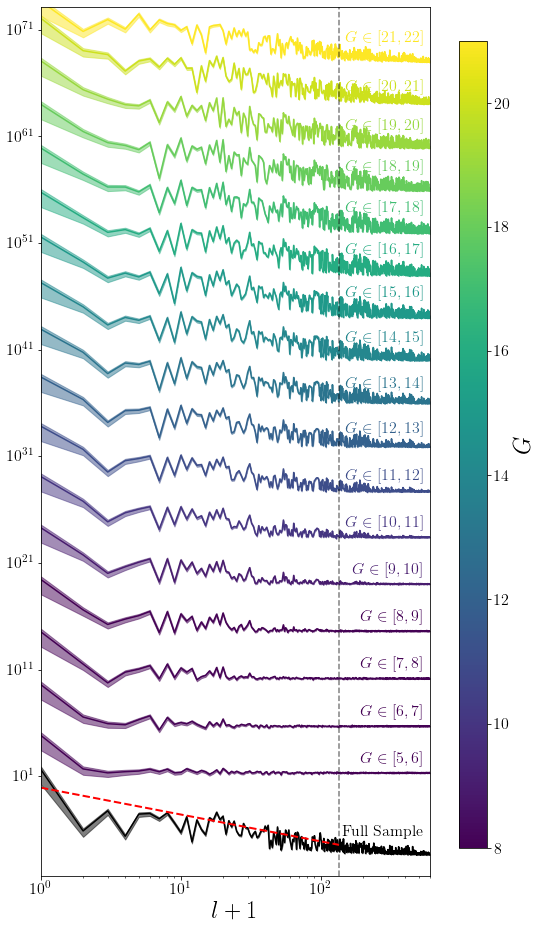

In [24]:
fig, ax = plt.subplots(1,1,figsize=(8,16))

cmap = cm.viridis; mmin=8.; mmax=21.

var_lower = scipy.stats.chi2.ppf(0.16, 2*lvals+1)/(2*lvals+1)
var_upper = scipy.stats.chi2.ppf(0.84, 2*lvals+1)/(2*lvals+1)
offset = 5; shift=2

for i, mag in tqdm.tqdm_notebook(enumerate(magbins[:-1]), total=len(magbins[:-1])):    
    spectrum = spectra[i].copy()
    plt.plot(lvals+1, spectrum*10**(2*float(offset+shift*i)), color=cmap((mag-mmin)/(mmax-mmin)))
    plt.fill_between(lvals+1, spectrum*var_lower*10**(2*float(offset+shift*i)), 
                    spectrum*var_upper*10**(2*float(offset+shift*i)), color=cmap((mag-mmin)/(mmax-mmin)),
                    alpha=0.5)

    plt.text(lmax*0.9, spectrum[lmax_fit]*10**(2*float(offset+shift*i+0.5)), r'$G\in[%.0f,%.0f]$'%(magbins[i],magbins[i+1]),
             ha='right', color=cmap((mag-mmin)/(mmax-mmin)))

spectrum = spectrum_full.copy()

plt.plot(lvals+1, spectrum, color='k')
plt.fill_between(lvals+1, spectrum*var_lower, spectrum*var_upper, color='k', alpha=0.5)
plt.plot(np.arange(lmax_fit)+1, model(np.arange(lmax_fit), result['x']),  '--r', linewidth=2)
plt.text(lmax*0.9, spectrum[lmax_fit]*10**(2*0.7), r'Full Sample', ha='right', color='k')
    

plt.yscale('log'); plt.xscale('log'); plt.xlabel(r'$l+1$', fontsize=24)
plt.ylim(np.min(spectra[M]/100), np.max(spectrum[M-1]*10**(2*float(offset+shift*(M-1)+0.15))*100))
plt.plot([lmax_fit,lmax_fit],[ax.get_ylim()[0],ax.get_ylim()[1]],'--k', alpha=0.5)
plt.xlim(1,lmax+1)


# Adding cbar axes to subplots
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=24)

#plt.savefig('figs/powerspectrum_plfit_ast.png', bbox_inches='tight', facecolor='w', transparent=False)

## RUWE

In [28]:
M = 17; C=1; nside=64
box={};
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_ruwe1p4_arr_hpx128.h', 'r') as hf:
    box['n'] = np.sum(hf['n'][...].reshape(*hf['n'][...].shape[:2], -1,4), axis=(3))
    box['k'] = np.sum(hf['k'][...].reshape(*hf['k'][...].shape[:2], -1,4), axis=(3))
    M_bins = hf['magbins'][...]
box['n'] = _downgrade(box['n'])
box['k'] = _downgrade(box['k'])
magbins = np.linspace(M_bins[0], M_bins[-1], M+1)

OSError: Unable to open file (unable to open file: name = '/data/asfe2/Projects/astrometry/gaia3_ruwe1p4_arr_hpx128.h', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

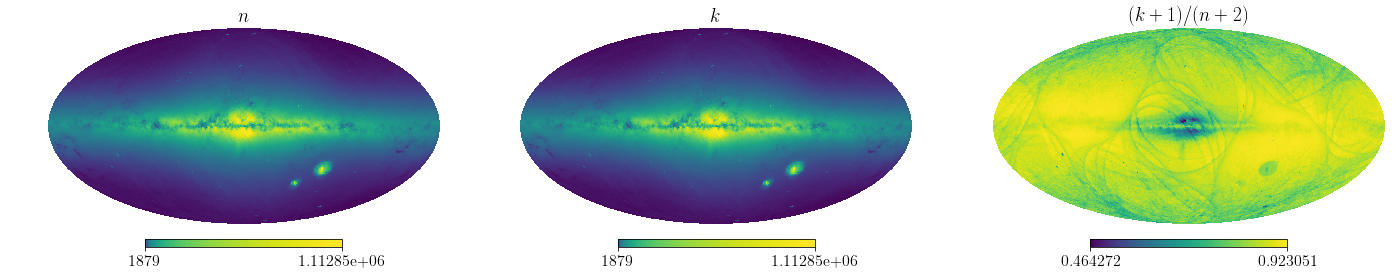

In [10]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(24,5))

minmax = np.min(box['n']), np.max(box['n'])

plt.sca(axes[0])
hp.mollview(np.sum(box['n'], axis=(0,1)), nest=True, notext=True, norm='log',# min=minmax[0], max=minmax[1],
            coord=['C','G'], title=r'$n$', cmap='viridis', hold=True, cbar=True, xsize=2000)

plt.sca(axes[1])
hp.mollview(np.sum(box['n'], axis=(0,1)), nest=True, notext=True, norm='log',#min=minmax[0], max=minmax[1],
            coord=['C','G'], title=r'$k$', cmap='viridis', hold=True, cbar=True, xsize=2000)

plt.sca(axes[2])
hp.mollview((np.sum(box['k'], axis=(0,1))+1)/(np.sum(box['n'], axis=(0,1))+2), nest=True, notext=True, norm='log',
            coord=['C','G'], title=r'$(k+1)/(n+2)$', cmap='viridis', hold=True, cbar=True, xsize=2000)

In [92]:
with h5py.File('/data/asfe2/Projects/astrometry/gaiaedr3_ruwe1p4_kncounts_Gres1Cres1hpx9_spectra.h', 'r') as hf:
    fullspectrum = hf['spectra_full'][...]
    spectra = hf['spectra'][...]
    magbins = hf['magbins'][...]
    M, C, P = hf['res'][...]
    colbins = np.linspace(-1,5,3)

In [93]:
lmax=600; lmax_fit=135
lvals = np.arange(lmax+1)

In [96]:
nll = lambda x: -loglike(lvals[:lmax_fit], fullspectrum[:lmax_fit], x)
result = scipy.optimize.minimize(nll, np.array([0.,-2]), method='Powell')
result

   direc: array([[ 0.        ,  1.        ],
       [ 2.39038406, -0.55666855]])
     fun: -31389.426486158838
 message: 'Optimization terminated successfully.'
    nfev: 110
     nit: 4
  status: 0
 success: True
       x: array([-0.0457807 , -2.61628449])

In [97]:
def nll(x):
    lnl, lnl_grad = loglike(lvals[:lmax_fit], fullspectrum[:lmax_fit], x, grad=True)
    return -lnl, -lnl_grad

result= scipy.optimize.minimize(nll, result['x'], method='Newton-CG', jac=True, options={'maxiter':1000})
result

     fun: -31389.42972315763
     jac: array([-0.00036609, -0.00111594])
 message: 'Optimization terminated successfully.'
    nfev: 4
    nhev: 0
     nit: 3
    njev: 16
  status: 0
 success: True
       x: array([-0.04331634, -2.61665505])

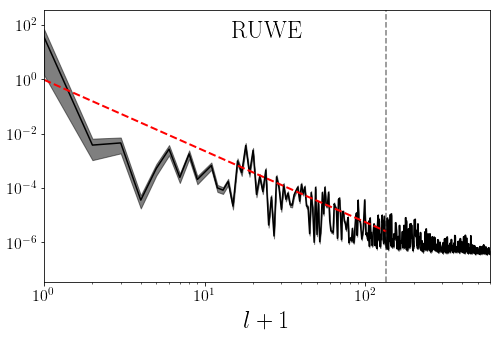

In [98]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

cmap = cm.viridis; mmin=8.; mmax=21.

var_lower = scipy.stats.chi2.ppf(0.16, 2*lvals+1)/(2*lvals+1)
var_upper = scipy.stats.chi2.ppf(0.84, 2*lvals+1)/(2*lvals+1)
offset = -1; shift=2

plt.plot(lvals+1, fullspectrum, color='k')
plt.fill_between(lvals+1, fullspectrum*var_lower, fullspectrum*var_upper, color='k', alpha=0.5)
plt.plot(np.arange(lmax_fit)+1, model(np.arange(lmax_fit), result['x']),  '--r', linewidth=2)
    

plt.yscale('log'); plt.xscale('log'); plt.xlabel(r'$l+1$', fontsize=24)
plt.ylim(np.min(fullspectrum/10), np.max(fullspectrum*10))
plt.xlim(1,lmax+1)

plt.text(lmax**0.5, ax.get_ylim()[1]**0.9 * ax.get_ylim()[0]**0.1, r'RUWE', ha='center', color='k', fontsize=24)

plt.plot([lmax_fit,lmax_fit],ax.get_ylim(),'--k', alpha=0.5)

#plt.savefig('figs/powerspectrum_betamean_fit-pl_ast_nside%d.png' % nside, bbox_inches='tight')

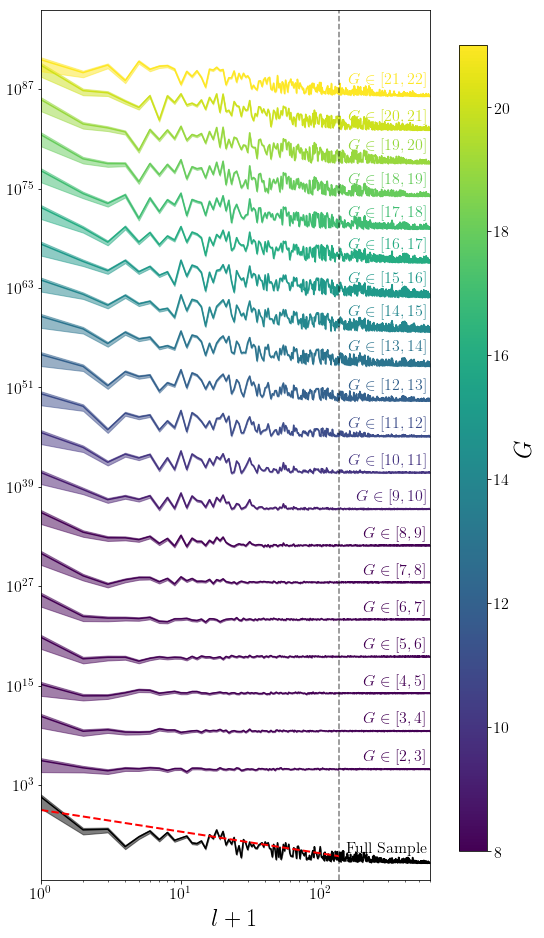

In [100]:
fig, ax = plt.subplots(1,1,figsize=(8,16))

cmap = cm.viridis; mmin=8.; mmax=21.

var_lower = scipy.stats.chi2.ppf(0.16, 2*lvals+1)/(2*lvals+1)
var_upper = scipy.stats.chi2.ppf(0.84, 2*lvals+1)/(2*lvals+1)
offset = 8; shift=2

for i, mag in tqdm.tqdm_notebook(enumerate(magbins[:-1]), total=len(magbins[:-1])):    
    spectrum = spectra[i,2].copy()
    plt.plot(lvals+1, spectrum*10**(2*float(offset+shift*i)), color=cmap((mag-mmin)/(mmax-mmin)))
    plt.fill_between(lvals+1, spectrum*var_lower*10**(2*float(offset+shift*i)), 
                    spectrum*var_upper*10**(2*float(offset+shift*i)), color=cmap((mag-mmin)/(mmax-mmin)),
                    alpha=0.5)

    plt.text(lmax*0.95, spectrum[lmax_fit]*10**(2*float(offset+shift*i+0.5)), r'$G\in[%.0f,%.0f]$'%(magbins[i],magbins[i+1]),
             ha='right', color=cmap((mag-mmin)/(mmax-mmin)))

spectrum = fullspectrum.copy()

plt.plot(lvals+1, spectrum, color='k')
plt.fill_between(lvals+1, spectrum*var_lower, spectrum*var_upper, color='k', alpha=0.5)
plt.plot(np.arange(lmax_fit)+1, model(np.arange(lmax_fit), result['x']),  '--r', linewidth=2)
plt.text(lmax*0.95, spectrum[lmax_fit]*10**(2*0.5), r'Full Sample', ha='right', color='k')
    

plt.yscale('log'); plt.xscale('log'); plt.xlabel(r'$l+1$', fontsize=24)
plt.ylim(np.min(fullspectrum/100), np.max(fullspectrum*10**(2*float(offset+shift*(M-1)+0.5))*100))
plt.plot([lmax_fit,lmax_fit],[ax.get_ylim()[0],ax.get_ylim()[1]],'--k', alpha=0.5)
plt.xlim(1,lmax+1)


# Adding cbar axes to subplots
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=24)

#plt.savefig('figs/powerspectrum_betamean_fit-pl_ast_nside%d.png' % nside, bbox_inches='tight')

# RVS

# Load in spectra

In [71]:
with h5py.File('/data/asfe2/Projects/astrometry/gaiaedr3_rvs_kncounts_Gres1Cres1hpx9_spectra.h', 'r') as hf:
    fullspectrum = hf['spectra_full'][...]
    spectra = hf['spectra'][...]
    magbins = hf['magbins'][...]
    M, C, P = hf['res'][...]
    colbins = np.linspace(-1,5,3)

In [72]:
lmax=600; lmax_fit=135
lvals = np.arange(lmax+1)

In [73]:
nll = lambda x: -loglike(lvals[:lmax_fit], fullspectrum[:lmax_fit], x)
result = scipy.optimize.minimize(nll, np.array([0.,-2]), method='Powell')
result

   direc: array([[ 0.        ,  1.        ],
       [ 3.13734337, -0.7269219 ]])
     fun: -28865.78883520189
 message: 'Optimization terminated successfully.'
    nfev: 108
     nit: 4
  status: 0
 success: True
       x: array([ 2.59962212, -2.77909557])

In [74]:
def nll(x):
    lnl, lnl_grad = loglike(lvals[:lmax_fit], fullspectrum[:lmax_fit], x, grad=True)
    return -lnl, -lnl_grad

result= scipy.optimize.minimize(nll, result['x'], method='Newton-CG', jac=True, options={'maxiter':1000})
result

     fun: -28865.790303988437
     jac: array([-0.00015419, -0.00052635])
 message: 'Optimization terminated successfully.'
    nfev: 4
    nhev: 0
     nit: 3
    njev: 18
  status: 0
 success: True
       x: array([ 2.60159016, -2.77941507])

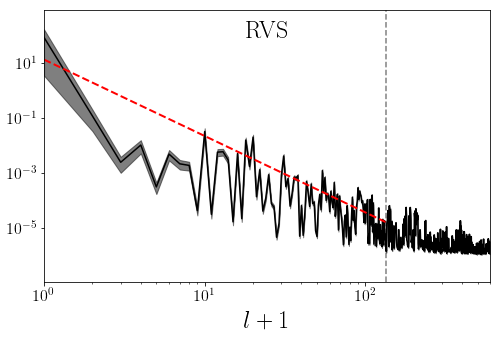

In [88]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

cmap = cm.viridis; mmin=8.; mmax=21.

var_lower = scipy.stats.chi2.ppf(0.16, 2*lvals+1)/(2*lvals+1)
var_upper = scipy.stats.chi2.ppf(0.84, 2*lvals+1)/(2*lvals+1)
offset = -1; shift=2

plt.plot(lvals+1, fullspectrum, color='k')
plt.fill_between(lvals+1, fullspectrum*var_lower, fullspectrum*var_upper, color='k', alpha=0.5)
plt.plot(np.arange(lmax_fit)+1, model(np.arange(lmax_fit), result['x']),  '--r', linewidth=2)
    

plt.yscale('log'); plt.xscale('log'); plt.xlabel(r'$l+1$', fontsize=24)
plt.ylim(np.min(fullspectrum/10), np.max(fullspectrum*10))
plt.xlim(1,lmax+1)

plt.text(lmax**0.5, ax.get_ylim()[1]**0.9 * ax.get_ylim()[0]**0.1, r'RVS', ha='center', color='k', fontsize=24)

plt.plot([lmax_fit,lmax_fit],ax.get_ylim(),'--k', alpha=0.5)

#plt.savefig('figs/powerspectrum_betamean_fit-pl_ast_nside%d.png' % nside, bbox_inches='tight')

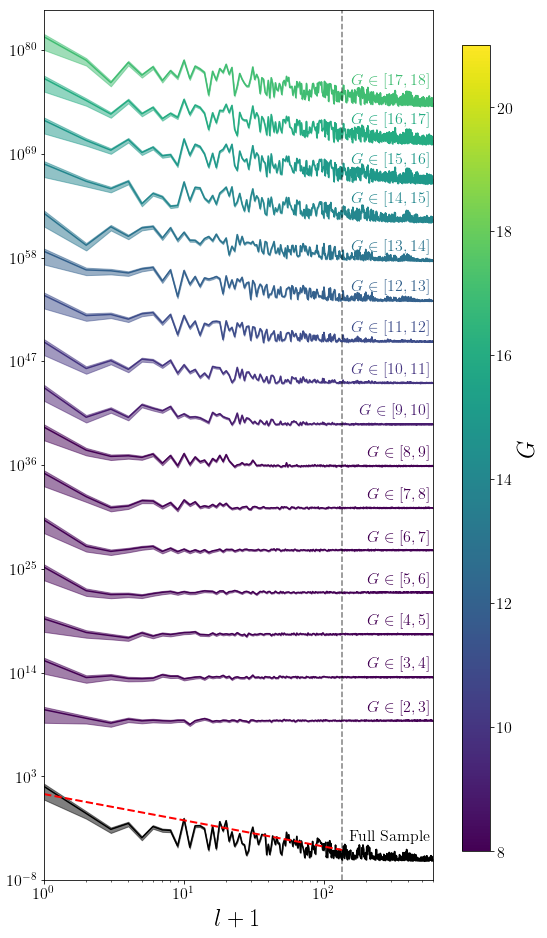

In [79]:
fig, ax = plt.subplots(1,1,figsize=(8,16))

cmap = cm.viridis; mmin=8.; mmax=21.

var_lower = scipy.stats.chi2.ppf(0.16, 2*lvals+1)/(2*lvals+1)
var_upper = scipy.stats.chi2.ppf(0.84, 2*lvals+1)/(2*lvals+1)
offset = 8; shift=2

for i, mag in tqdm.tqdm_notebook(enumerate(magbins[1:-1]), total=len(magbins[1:-1])):    
    i+=1
    spectrum = spectra[i,2].copy()
    plt.plot(lvals+1, spectrum*10**(2*float(offset+shift*i)), color=cmap((mag-mmin)/(mmax-mmin)))
    plt.fill_between(lvals+1, spectrum*var_lower*10**(2*float(offset+shift*i)), 
                    spectrum*var_upper*10**(2*float(offset+shift*i)), color=cmap((mag-mmin)/(mmax-mmin)),
                    alpha=0.5)

    plt.text(lmax*0.95, spectrum[lmax_fit]*10**(2*float(offset+shift*i+0.5)), r'$G\in[%.0f,%.0f]$'%(magbins[i],magbins[i+1]),
             ha='right', color=cmap((mag-mmin)/(mmax-mmin)))

spectrum = fullspectrum.copy()

plt.plot(lvals+1, spectrum, color='k')
plt.fill_between(lvals+1, spectrum*var_lower, spectrum*var_upper, color='k', alpha=0.5)
plt.plot(np.arange(lmax_fit)+1, model(np.arange(lmax_fit), result['x']),  '--r', linewidth=2)
plt.text(lmax*0.95, spectrum[lmax_fit]*10**(2*0.5), r'Full Sample', ha='right', color='k')
    

plt.yscale('log'); plt.xscale('log'); plt.xlabel(r'$l+1$', fontsize=24)
plt.ylim(np.min(fullspectrum/100), np.max(fullspectrum*10**(2*float(offset+shift*(M-1)+0.15))*100))
plt.plot([lmax_fit,lmax_fit],[ax.get_ylim()[0],ax.get_ylim()[1]],'--k', alpha=0.5)
plt.xlim(1,lmax+1)


# Adding cbar axes to subplots
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=24)

#plt.savefig('figs/powerspectrum_betamean_fit-pl_ast_nside%d.png' % nside, bbox_inches='tight')

In [25]:
spectra = {}
with h5py.File('/data/asfe2/Projects/astrometry/gaiaedr3_astrometry_kncounts_Gres1hpx10_spectra.h', 'r') as hf:
    spectra['ast'] = hf['spectra'][-1][...]
        
with h5py.File('/data/asfe2/Projects/astrometry/gaiaedr3_rvs_kncounts_Gres1Cres1hpx9_spectra.h', 'r') as hf:
    spectra['rvs'] = hf['spectra_full'][...]
        
with h5py.File('/data/asfe2/Projects/astrometry/gaiaedr3_ruwe1p4_kncounts_Gres1Cres1hpx9_spectra.h', 'r') as hf:
    spectra['ruwe'] = hf['spectra_full'][...]

In [15]:
spectra = {}
with h5py.File('/data/asfe2/Projects/astrometry/gaiaedr3_astrometry_kncounts_M17C1nside128_spectra.h', 'r') as hf:
    spectra['ast'] = hf['spectra_full'][...]
        
with h5py.File('/data/asfe2/Projects/astrometry/gaiaedr3_rvs_kncounts_M13C3nside128_spectra.h', 'r') as hf:
    spectra['rvs'] = hf['spectra_full'][...]
        
with h5py.File('/data/asfe2/Projects/astrometry/gaiaedr3_ruwe1p4_kncounts_M17C3nside128_spectra.h', 'r') as hf:
    spectra['ruwe'] = hf['spectra_full'][...]

In [14]:
spectra['ast'].shape

(1, 401)

In [16]:
lmax=400; lmax_fit=135
lvals = np.arange(lmax+1)

fits = {}

for sample in spectra:
    #nll = lambda x: -loglike(lvals[:lmax_fit], spectra[sample][:lmax_fit], x)
    #result = scipy.optimize.minimize(nll, np.array([0.,-2]), method='Powell')
    #result

    def nll(x):
        lnl, lnl_grad = loglike(lvals[:lmax_fit], spectra[sample][:lmax_fit], x, grad=True)
        return -lnl, -lnl_grad

    result= scipy.optimize.minimize(nll, np.array([0.,-2]), method='Newton-CG', jac=True, options={'maxiter':1000})
    fits[sample] = result['x']

In [17]:
fits

{'ast': array([-0.67227718, -2.35088459]),
 'rvs': array([ 0.15969954, -2.28714378]),
 'ruwe': array([-0.6313727 , -2.43890241])}

In [27]:
fits

{'ast': array([-0.15377931, -2.51599939]),
 'rvs': array([ 2.60159016, -2.77941507]),
 'ruwe': array([-0.04466587, -2.61635365])}

In [11]:
fits

{'ast': array([-0.1537701 , -2.51600146]),
 'rvs': array([ 2.60159016, -2.77941507]),
 'ruwe': array([-0.04331634, -2.61665505])}

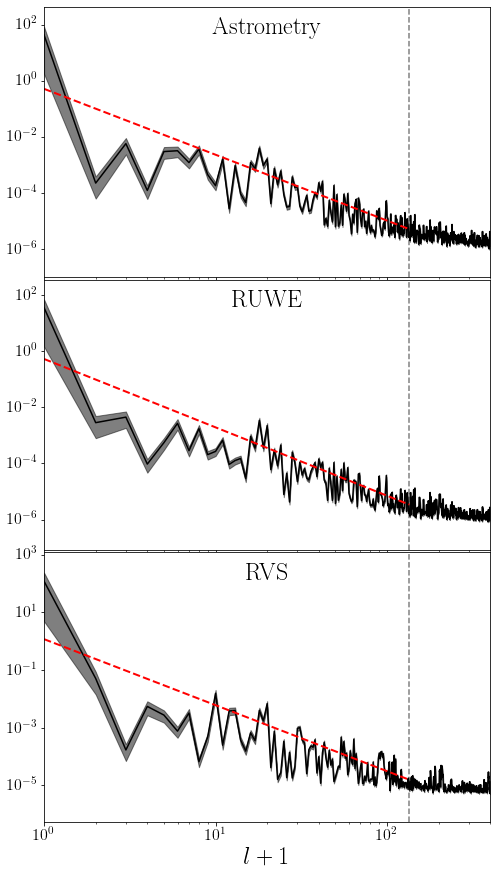

In [20]:
fig, axes = plt.subplots(3,1,figsize=(8,15), sharex=True)

var_lower = scipy.stats.chi2.ppf(0.16, 2*lvals+1)/(2*lvals+1)
var_upper = scipy.stats.chi2.ppf(0.84, 2*lvals+1)/(2*lvals+1)
labels={'ast':'Astrometry','ruwe':r'$\mathrm{RUWE}$','rvs':'RVS'}

for i, sample in enumerate(['ast','ruwe','rvs']):
    ax = axes[i]
    plt.sca(ax)
    
    plt.plot(lvals+1, spectra[sample], color='k')
    plt.fill_between(lvals+1, spectra[sample]*var_lower, spectra[sample]*var_upper, color='k', alpha=0.5)
    plt.plot(np.arange(lmax_fit)+1, model(np.arange(lmax_fit), fits[sample]),  '--r', linewidth=2)


    plt.yscale('log');
    plt.ylim(np.min(spectra[sample]/10), np.max(spectra[sample]*10))
    plt.xlim(1,lmax+1)

    plt.text(lmax**0.5, ax.get_ylim()[1]**0.9 * ax.get_ylim()[0]**0.1, labels[sample], ha='center', color='k', fontsize=24)

    plt.plot([lmax_fit,lmax_fit],ax.get_ylim(),'--k', alpha=0.5)

plt.xscale('log'); plt.xlabel(r'$l+1$', fontsize=24)
plt.subplots_adjust(hspace=0.01)

plt.savefig(f'figs/powerspectra_3samples_plfit.png', bbox_inches='tight', facecolor='w', transparent=False)

# G-G_RP

In [30]:
spectra = {}
with h5py.File('/data/asfe2/Projects/astrometry/gaiaedr3_astrometry_kncounts_M17C1nside128_spectra.h', 'r') as hf:
    spectra['ast'] = hf['spectra_full'][...]
        
with h5py.File('/data/asfe2/Projects/astrometry/gaiaedr3_rvs_kncounts_M13C4nside128_spectra.h', 'r') as hf:
    spectra['rvs'] = hf['spectra_full'][...]
        
with h5py.File('/data/asfe2/Projects/astrometry/gaiaedr3_ruwe1p4_kncounts_M17C4nside128_spectra.h', 'r') as hf:
    spectra['ruwe'] = hf['spectra_full'][...]

In [32]:
lmax=400; lmax_fit=135
lvals = np.arange(lmax+1)

fits = {}

for sample in spectra:
    #nll = lambda x: -loglike(lvals[:lmax_fit], spectra[sample][:lmax_fit], x)
    #result = scipy.optimize.minimize(nll, np.array([0.,-2]), method='Powell')
    #result

    def nll(x):
        lnl, lnl_grad = loglike(lvals[:lmax_fit], spectra[sample][:lmax_fit], x, grad=True)
        return -lnl, -lnl_grad

    result= scipy.optimize.minimize(nll, np.array([0.,-2]), method='Newton-CG', jac=True, options={'maxiter':1000})
    fits[sample] = result['x']

In [35]:
hp.nside2npix(2**0)

12

In [33]:
fits

{'ast': array([-0.67227718, -2.35088459]),
 'rvs': array([-0.0755305 , -2.24756519]),
 'ruwe': array([-0.21051177, -2.48372204])}

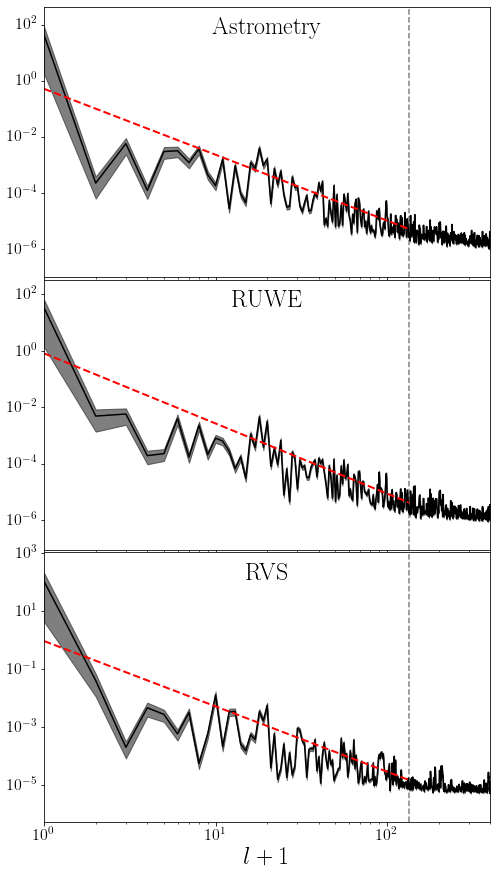

In [34]:
fig, axes = plt.subplots(3,1,figsize=(8,15), sharex=True)

var_lower = scipy.stats.chi2.ppf(0.16, 2*lvals+1)/(2*lvals+1)
var_upper = scipy.stats.chi2.ppf(0.84, 2*lvals+1)/(2*lvals+1)
labels={'ast':'Astrometry','ruwe':r'$\mathrm{RUWE}$','rvs':'RVS'}

for i, sample in enumerate(['ast','ruwe','rvs']):
    ax = axes[i]
    plt.sca(ax)
    
    plt.plot(lvals+1, spectra[sample], color='k')
    plt.fill_between(lvals+1, spectra[sample]*var_lower, spectra[sample]*var_upper, color='k', alpha=0.5)
    plt.plot(np.arange(lmax_fit)+1, model(np.arange(lmax_fit), fits[sample]),  '--r', linewidth=2)


    plt.yscale('log');
    plt.ylim(np.min(spectra[sample]/10), np.max(spectra[sample]*10))
    plt.xlim(1,lmax+1)

    plt.text(lmax**0.5, ax.get_ylim()[1]**0.9 * ax.get_ylim()[0]**0.1, labels[sample], ha='center', color='k', fontsize=24)

    plt.plot([lmax_fit,lmax_fit],ax.get_ylim(),'--k', alpha=0.5)

plt.xscale('log'); plt.xlabel(r'$l+1$', fontsize=24)
plt.subplots_adjust(hspace=0.01)

plt.savefig(f'figs/powerspectra_3samples_plfit.png', bbox_inches='tight', facecolor='w', transparent=False)

In [11]:
spectra = {}
with h5py.File('/data/asfe2/Projects/astrometry/gaiaedr3_astrometry_kncounts_Gres1hpx10_spectra.h', 'r') as hf:
    spectra['ast'] = hf['spectra'][-1][...]

In [14]:
lmax=600; lmax_fit=135
lvals = np.arange(lmax+1)

fits = {}
sample = 'ast'

nll = lambda x: -loglike(lvals[:lmax_fit], spectra[sample][:lmax_fit], x)
result = scipy.optimize.minimize(nll, np.array([0.,-2]), method='Powell')
result

   direc: array([[ 1.12012868, -0.26525067],
       [ 0.00800346, -0.00118389]])
     fun: 7827.533163697261
 message: 'Optimization terminated successfully.'
    nfev: 158
     nit: 5
  status: 0
 success: True
       x: array([ 1.62499465, -2.7359849 ])

In [19]:
def nll(x):
    lnl, lnl_grad = loglike(lvals[:lmax_fit], spectra[sample][:lmax_fit], x, grad=True)
    return -lnl, -lnl_grad

result= scipy.optimize.minimize(nll, result['x'], method='Newton-CG', jac=True, options={'maxiter':1000})
fits[sample] = result['x']

In [20]:
result

     fun: 7827.533163697182
     jac: array([0.00113187, 0.00749108])
 message: 'Optimization terminated successfully.'
    nfev: 2
    nhev: 0
     nit: 1
    njev: 4
  status: 0
 success: True
       x: array([ 1.62499464, -2.73598492])

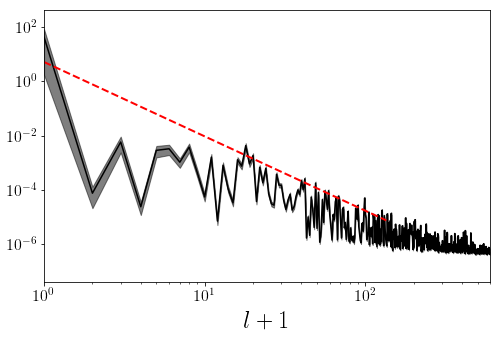

In [26]:
fig, axes = plt.subplots(1,1,figsize=(8,5), sharex=True)

var_lower = scipy.stats.chi2.ppf(0.16, 2*lvals+1)/(2*lvals+1)
var_upper = scipy.stats.chi2.ppf(0.84, 2*lvals+1)/(2*lvals+1)
labels={'ast':'Astrometry','ruwe':r'$\mathrm{RUWE<1.4}$','rvs':'RVS'}

plt.plot(lvals+1, spectra[sample], color='k')
plt.fill_between(lvals+1, spectra[sample]*var_lower, spectra[sample]*var_upper, color='k', alpha=0.5)
plt.plot(np.arange(lmax_fit)+1, model(np.arange(lmax_fit), fits[sample]),  '--r', linewidth=2)


plt.yscale('log');
plt.ylim(np.min(spectra[sample]/10), np.max(spectra[sample]*10))
plt.xlim(1,lmax+1)

#plt.text(lmax**0.5, ax.get_ylim()[1]**0.9 * ax.get_ylim()[0]**0.1, labels[sample], ha='center', color='k', fontsize=24)

#plt.plot([lmax_fit,lmax_fit],ax.get_ylim(),'--k', alpha=0.5)

plt.xscale('log'); plt.xlabel(r'$l+1$', fontsize=24)
plt.subplots_adjust(hspace=0.01)

In [18]:
def loglike(l, Cl, params, grad=False):
    if not grad:
        fl = model(l, params)
        lnl = np.sum( -2*np.log(fl) - (2*l+1)*(fl-Cl)**2 / fl**2 )
        if np.isnan(lnl): print(params)
        return lnl
    else: 
        fl, fl_grad = model(l, params, grad=grad)
        lnl_val = np.sum( -2*np.log(fl) - (2*l+1)*(fl-Cl)**2 / fl**2 )
        dlnl_dfl = -2/fl - 2*(2*l+1)*( (fl-Cl)/fl**2 - (fl-Cl)**2 / fl**3 )
        lnl_grad = np.sum(dlnl_dfl * fl_grad, axis=1)
        
        return lnl_val, lnl_grad

In [38]:
s = np.random.choice(np.arange(5), size=50, replace=True)

In [39]:
sigma = np.unique(s, return_index=True)
print(sigma[0][np.argsort(sigma[1])])

[0 4 2 3 1]


In [40]:
s

array([0, 4, 2, 3, 3, 4, 3, 1, 1, 2, 2, 2, 3, 4, 0, 4, 2, 3, 4, 2, 1, 0,
       0, 0, 3, 3, 3, 2, 0, 0, 2, 1, 1, 2, 3, 4, 3, 0, 2, 2, 3, 0, 2, 2,
       1, 1, 2, 2, 3, 2])

# Normalisation

In [41]:
import numpy as np
def window(j, l=1, B=2.0, p=1.0):
    w = l*(l+1) / (B**(2*j))
    return w**p * np.exp(-w)

In [42]:
j = np.arange(0,1500)

In [43]:
window(j, l=100)[:10]**2

/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 2.09936015e-133,
       8.38713926e-032, 2.63575837e-007, 4.38670613e-002, 1.10753330e-001,
       1.74510421e-002, 1.37435056e-003])

In [44]:
np.sum(window(j, l=1)**2), np.sum(window(j, l=10)**2), np.sum(window(j, l=30)**2), np.sum(window(j, l=50)**2)

/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


(0.17838271644821116,
 0.18322721383842058,
 0.17917421266975106,
 0.17343876882249196)